In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Must be before importing keras!
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")
import tf_memory_limit
#import matplotlib; matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or before importing pylab!
from keras import backend as K
import tensorflow as tf
import numpy as np
import ctcfgen
import ucscgenome
from convnet import Bias
from keras.models import load_model, Model
from keras.layers import Input, Activation
import viz_sequence
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# what data are we looking at?
TF_dir = '/home/kal/CTCF/mystery_seq/data/HumanTFs/'
TF_file = 'K562.CTCF-human.narrowPeak.bed'

Using TensorFlow backend.


In [2]:
# load in chip-seq regions
full_peaks = pd.read_table(os.path.join(TF_dir, TF_file), header=None)
# encode narrow-peak formatt for columns
full_peaks.columns = 'chr start end name score strand signalValue pValue qValue peak'.split()

# load the model
#model_path = '/home/kal/CTCF/mass_CTCF/output/sigmoid/20170919_150754/20170919_150754_weights_3_248_0.91.hdf5'
#model = load_model(model_path, custom_objects={'Bias':Bias})
#layer_dict = dict([(layer.name, layer) for layer in model.layers])

# or load the strength model
model_path = '/home/kal/CTCF/mass_CTCF/output/strength/20171128_132105/20171128_132105_weights_3_247_45227.62.hdf5'
model = load_model(model_path, custom_objects={'Bias':Bias})
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# get a function for pre-activation model value (this is better to use as a 'score')
get_act = K.function([model.input, K.learning_phase()], [layer_dict['bias'].output])

#load the genome
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

# get the cell type
cell_type = TF_file.split('.')[0]

In [3]:
# get a subset of the data to work with
peaks = full_peaks

In [4]:
# add annotations of pwm scores, relative distance, and orentation
# add annotations to the peaks
count = 0
file_length = len(peaks)
for index, row in peaks.iterrows():
    count = count + 1
    # get the sequence
    center = (row.start + row.end) // 2
    if center < 128:
        center = 128
    seq = ctcfgen.encode(np.fromstring(genome[row.chr][center-128:center+128].lower(), dtype=np.uint8))
    
    # add the model score
    peaks.set_value(index,'ml_score', get_act([np.asarray([seq]*32),0])[0][0])

    # add the ctcf pwm score
    score, pwm, cmeme, cmeme_index, cposition = ctcfgen.get_pwm([seq], get_everything=True)
    peaks.set_value(index,'ctcf', score)
    peaks.set_value(index,'ctcf_orentation', (cmeme_index>1))
    peaks.set_value(index,'ctcf_position', cposition)
  
    # add the mystery pwm score
    score, pwm, mmeme, mmeme_index, mposition = ctcfgen.get_pwm([seq], get_everything=True, meme_library='mystery_memes')
    peaks.set_value(index,'mystery', score)
    peaks.set_value(index,'mystery_orentation', (mmeme_index>0))
    peaks.set_value(index,'mystery_position', mposition)
    if count % 1000 == 0:
        print('%.2f' % (count / file_length * 100) + ' %')
    
    #distance/orentation calculation
    mcenter = mposition + mmeme.shape[0]/2 
    distance = mcenter - (cposition + cmeme.shape[0]/2)
    if (cmeme_index<2):
        #ctcf forward
        peaks.set_value(index,'distance', distance)
        if (mmeme_index < 1):
            # mystery forward
            peaks.set_value(index, 'omatch', 0) #match
        else:
            peaks.set_value(index, 'omatch', 1) #opposite        
    else:
        # ctcf reversed
        peaks.set_value(index,'distance', -distance)
        if (mmeme_index < 1):
            # mystery forward
            peaks.set_value(index, 'omatch', 1) #opposite
        else:
            peaks.set_value(index, 'omatch', 0) #match
    
peaks['old_distance'] = peaks['mystery_position'] - peaks['ctcf_position']

2.19 %
4.39 %
6.58 %
8.77 %
10.96 %
13.16 %
15.35 %
17.54 %
19.74 %
21.93 %
24.12 %
26.31 %
28.51 %
30.70 %
32.89 %
35.09 %
37.28 %
39.47 %
41.66 %
43.86 %
46.05 %
48.24 %
50.44 %
52.63 %
54.82 %
57.01 %
59.21 %
61.40 %
63.59 %
65.79 %
67.98 %
70.17 %
72.36 %
74.56 %
76.75 %
78.94 %
81.14 %
83.33 %
85.52 %
87.71 %
89.91 %
92.10 %
94.29 %
96.48 %
98.68 %


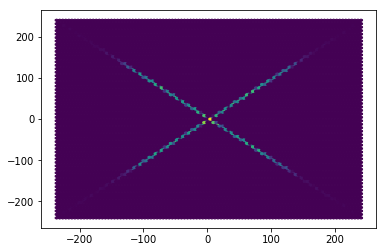

In [5]:
peaks['old_distance'] = peaks['mystery_position'] - peaks['ctcf_position']
plt.hexbin(peaks['old_distance'], peaks['distance'])
plt.show()

In [6]:
# add orentation index
# 1: mystery first
# 2: convergent
# 3: ctcf first
# 4: divergent

for index, row in peaks.iterrows():
    if row['distance'] > 0:
    # mystery ahead
        if (cmeme_index<2):
            #forward
            if (row['mystery_orentation'] < 1):
                # mystery aligned --> ctcf first
                peaks.set_value(index, 'orentation', 3)
            else:
                # mystery opposite --> converegent
                    peaks.set_value(index, 'orentation', 2)
        else:
                #forward
            if (row['mystery_orentation'] < 1):
                # mystery aligned --> ctcf first
                peaks.set_value(index, 'orentation', 2)
            else:
                # mystery opposite --> converegent
                    peaks.set_value(index, 'orentation', 3)
    else:
        # mystery downstream
        if (cmeme_index<2):
            #forward
            if (row['mystery_orentation'] < 1):
                # mystery aligned --> mystery first
                peaks.set_value(index, 'orentation', 1)
            else:
                # mystery opposite --> divergent
                peaks.set_value(index, 'orentation', 4)
        else:
            if (row['mystery_orentation'] < 1):
                # mystery aligned --> mystery first
                peaks.set_value(index, 'orentation', 4)
            else:
                # mystery opposite --> divergent
                peaks.set_value(index, 'orentation', 1)

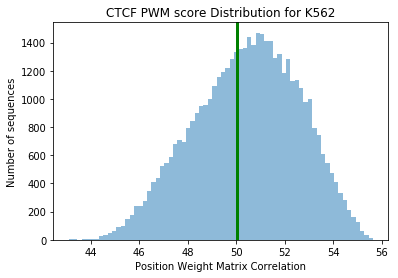

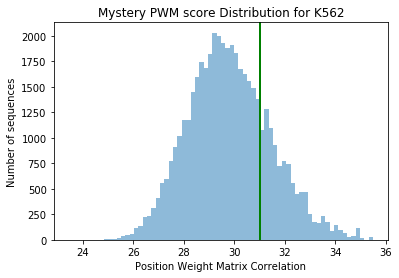

In [7]:
# get an idea of the score distribution
ctcf_cutoff = 50
mystery_cutoff = 31


plt.hist(peaks['ctcf'], 70, alpha=.5)
plt.axvspan(ctcf_cutoff, ctcf_cutoff + .1, facecolor='g')
plt.title('CTCF PWM score Distribution for ' + cell_type)
plt.ylabel('Number of sequences')
plt.xlabel('Position Weight Matrix Correlation')
plt.show()

plt.hist(peaks['mystery'], 70, alpha=.5)
plt.axvspan(mystery_cutoff, mystery_cutoff + .05, facecolor='g')
plt.title('Mystery PWM score Distribution for ' + cell_type)
plt.ylabel('Number of sequences')
plt.xlabel('Position Weight Matrix Correlation')
plt.show()

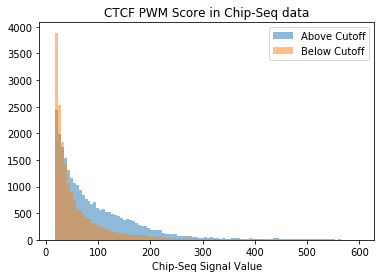

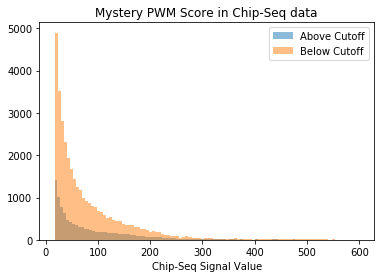

In [8]:
# get an idea of the score distribution
plt.hist(peaks[(peaks['ctcf'] > ctcf_cutoff)]['signalValue'], 100, alpha=.5, label='Above Cutoff')
plt.hist(peaks[(peaks['ctcf'] <= ctcf_cutoff)]['signalValue'], 100, alpha=.5, label='Below Cutoff')
plt.title('CTCF PWM Score in Chip-Seq data')
plt.xlabel('Chip-Seq Signal Value')
plt.legend()
plt.show()

plt.hist(peaks[(peaks['mystery'] > mystery_cutoff)]['signalValue'], 100, alpha=.5, label='Above Cutoff')
plt.hist(peaks[(peaks['mystery'] <= mystery_cutoff)]['signalValue'], 100, alpha=.5, label='Below Cutoff')
plt.title('Mystery PWM Score in Chip-Seq data')
plt.xlabel('Chip-Seq Signal Value')
plt.legend()
plt.show()

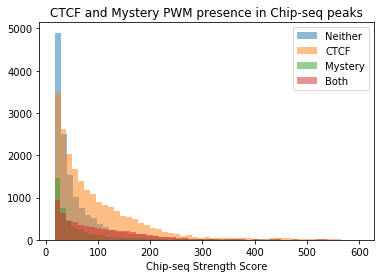

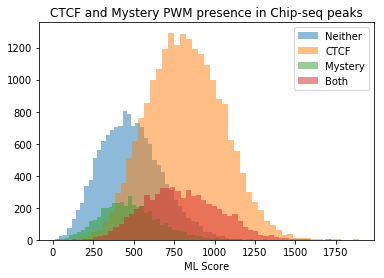

In [9]:
#split the data
both = peaks[(peaks['ctcf'] > ctcf_cutoff) & (peaks['mystery'] > mystery_cutoff)]
ctcf_only = peaks[(peaks['ctcf'] > ctcf_cutoff) & (peaks['mystery'] < mystery_cutoff)]
mystery_only = peaks[(peaks['ctcf'] < ctcf_cutoff) & (peaks['mystery'] > mystery_cutoff)]
neither = peaks[(peaks['ctcf'] < ctcf_cutoff) & (peaks['mystery'] < mystery_cutoff)]

# dead canadian plot
plt.hist(neither['signalValue'], alpha=0.5, bins=50, label='Neither')
plt.hist(ctcf_only['signalValue'], alpha=0.5, bins=50, label='CTCF')
plt.hist(mystery_only['signalValue'], alpha=0.5, bins=50, label='Mystery')
plt.hist(both['signalValue'], alpha=0.5, bins=50, label='Both')
plt.legend()
plt.title('CTCF and Mystery PWM presence in Chip-seq peaks')
plt.xlabel('Chip-seq Strength Score')
plt.show()


# dead canadian plot
plt.hist(neither['ml_score'], alpha=0.5, bins=50, label='Neither')
plt.hist(ctcf_only['ml_score'], alpha=0.5, bins=50, label='CTCF')
plt.hist(mystery_only['ml_score'], alpha=0.5, bins=50, label='Mystery')
plt.hist(both['ml_score'], alpha=0.5, bins=50, label='Both')
plt.legend()
plt.title('CTCF and Mystery PWM presence in Chip-seq peaks')
plt.xlabel('ML Score')
plt.show()

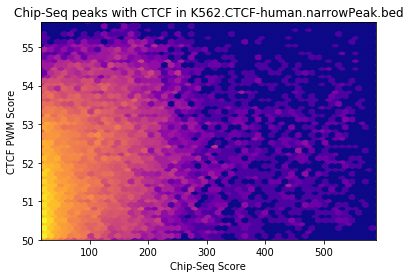

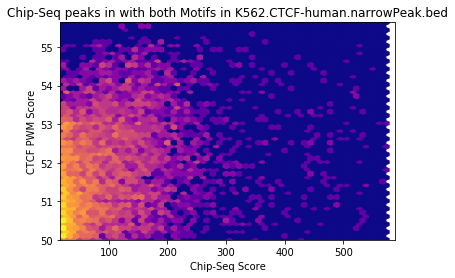

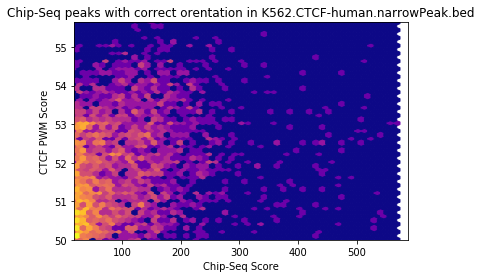

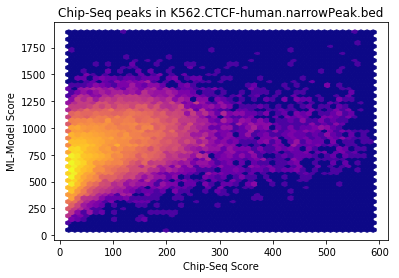

In [10]:
# get an idea of distribution shifts
# plot the distribution of chip-seq and ctcf pwm scores
plt.hexbin(peaks[(peaks['ctcf'] > ctcf_cutoff)]['signalValue'], peaks[(peaks['ctcf'] > ctcf_cutoff)]['ctcf'], gridsize=50, bins='log', cmap='plasma')
plt.title('Chip-Seq peaks with CTCF in ' + str(TF_file))
plt.axis([min(peaks[(peaks['ctcf'] > ctcf_cutoff)]['signalValue']), max(peaks[(peaks['ctcf'] > ctcf_cutoff)]['signalValue']), min(peaks[(peaks['ctcf'] > ctcf_cutoff)]['ctcf']), max(peaks[(peaks['ctcf'] > ctcf_cutoff)]['ctcf'])])
plt.xlabel('Chip-Seq Score')
plt.ylabel('CTCF PWM Score')
plt.show()

# for peaks with both
plt.hexbin(both['signalValue'], both['ctcf'], gridsize=50, bins='log', cmap='plasma', )
plt.axis([min(peaks[(peaks['ctcf'] > ctcf_cutoff)]['signalValue']), max(peaks[(peaks['ctcf'] > ctcf_cutoff)]['signalValue']), min(peaks[(peaks['ctcf'] > ctcf_cutoff)]['ctcf']), max(peaks[(peaks['ctcf'] > ctcf_cutoff)]['ctcf'])])
plt.title('Chip-Seq peaks in with both Motifs in ' + str(TF_file))
plt.xlabel('Chip-Seq Score')
plt.ylabel('CTCF PWM Score')
plt.show()

# for peaks with both and correct orentation
plt.hexbin(both[(abs(both['orentation']-2.5) < 1)]['signalValue'], both[(abs(both['orentation']-2.5) < 1)]['ctcf'], gridsize=50, bins='log', cmap='plasma')
plt.axis([min(peaks[(peaks['ctcf'] > ctcf_cutoff)]['signalValue']), max(peaks[(peaks['ctcf'] > ctcf_cutoff)]['signalValue']), min(peaks[(peaks['ctcf'] > ctcf_cutoff)]['ctcf']), max(peaks[(peaks['ctcf'] > ctcf_cutoff)]['ctcf'])])
plt.title('Chip-Seq peaks with correct orentation in ' + str(TF_file))
plt.xlabel('Chip-Seq Score')
plt.ylabel('CTCF PWM Score')
plt.show()

# plot the distribution of chip-seq and ctcf pwm scores
plt.hexbin(peaks[(peaks['ctcf'] > ctcf_cutoff)]['signalValue'], peaks[(peaks['ctcf'] > ctcf_cutoff)]['ml_score'], gridsize=50, bins='log', cmap='plasma')
plt.title('Chip-Seq peaks in ' + str(TF_file))
plt.xlabel('Chip-Seq Score')
plt.ylabel('ML-Model Score')
plt.show()

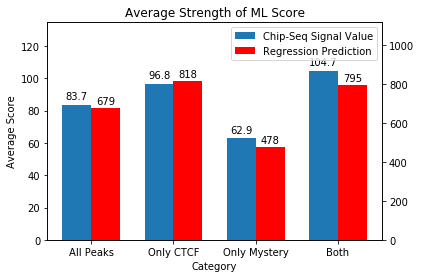

In [11]:
# plot average strength
labels = ('All Peaks', 'Only CTCF', 'Only Mystery', 'Both')
props = [sum(peaks['signalValue'])/len(peaks)]
props.append(sum(ctcf_only['signalValue'])/len(ctcf_only))
props.append(sum(mystery_only['signalValue'])/len(mystery_only))
props.append(sum(both['signalValue'])/len(both))

N=4
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
score = ax.bar(ind, props, width)
ax.set_ylim(top=max(props) + 30)

rects = ax.patches

# Now make some labels
for rect, value in zip(rects, props):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 2, '%.1f' %value, ha='center', va='bottom')

# plot average strength
props = [sum(peaks['ml_score'])/len(peaks)]
props.append(sum(ctcf_only['ml_score'])/len(ctcf_only))
props.append(sum(mystery_only['ml_score'])/len(mystery_only))
props.append(sum(both['ml_score'])/len(both))

ax2 = ax.twinx()
ml = ax2.bar(ind+width, props, width, color='r')
ax2.set_ylim(top=max(props) + 300)

ax.set_title("Average Strength of ML Score")
ax.set_xlabel("Category")
ax.set_ylabel("Average Score")
ax2.legend((score[0], ml[0]), ('Chip-Seq Signal Value', 'Regression Prediction'))

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels, rotation=0)

rects = ax2.patches

# Now make some labels
for rect, value in zip(rects, props):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, height + 10, '%.0f' %value, ha='center', va='bottom')
    
plt.show()

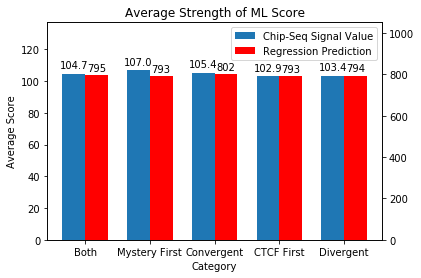

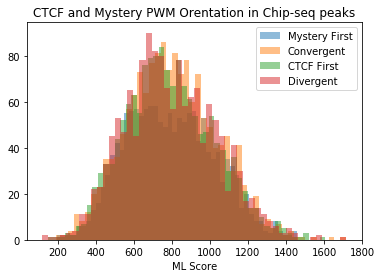

In [12]:
# plot average strength
# plot average strength
labels = ('Both', 'Mystery First', 'Convergent', 'CTCF First', 'Divergent')
props = [sum(both['signalValue'])/len(both)]
props.append(sum(both[both['orentation'] == 1]['signalValue'])/len(both[both['orentation'] == 1]))
props.append(sum(both[both['orentation'] == 2]['signalValue'])/len(both[both['orentation'] == 2]))
props.append(sum(both[both['orentation'] == 3]['signalValue'])/len(both[both['orentation'] == 3]))
props.append(sum(both[both['orentation'] == 4]['signalValue'])/len(both[both['orentation'] == 4]))

N=5
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
score = ax.bar(ind, props, width)
ax.set_ylim(top=max(props) + 30)

rects = ax.patches

# Now make some labels
for rect, value in zip(rects, props):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 2, '%.1f' %value, ha='center', va='bottom')

# plot average strength
props = [sum(both['ml_score'])/len(both)]
props.append(sum(both[both['orentation'] == 1]['ml_score'])/len(both[both['orentation'] == 1]))
props.append(sum(both[both['orentation'] == 2]['ml_score'])/len(both[both['orentation'] == 2]))
props.append(sum(both[both['orentation'] == 3]['ml_score'])/len(both[both['orentation'] == 3]))
props.append(sum(both[both['orentation'] == 4]['ml_score'])/len(both[both['orentation'] == 4]))

ax2 = ax.twinx()
ml = ax2.bar(ind+width, props, width, color='r')
ax2.set_ylim(top=max(props) + 250)

ax.set_title("Average Strength of ML Score")
ax.set_xlabel("Category")
ax.set_ylabel("Average Score")
ax2.legend((score[0], ml[0]), ('Chip-Seq Signal Value', 'Regression Prediction'))

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels, rotation=0)

rects = ax2.patches

# Now make some labels
for rect, value in zip(rects, props):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, height + 10, '%.0f' %value, ha='center', va='bottom')
    
plt.show()


# dead canadian plot
plt.hist(both[both['orentation'] == 1]['ml_score'], alpha=0.5, bins=50, label='Mystery First')
plt.hist(both[both['orentation'] == 2]['ml_score'], alpha=0.5, bins=50, label='Convergent')
plt.hist(both[both['orentation'] == 3]['ml_score'], alpha=0.5, bins=50, label='CTCF First')
plt.hist(both[both['orentation'] == 4]['ml_score'], alpha=0.5, bins=50, label='Divergent')
plt.legend()
plt.title('CTCF and Mystery PWM Orentation in Chip-seq peaks')
plt.xlabel('ML Score')
plt.show()

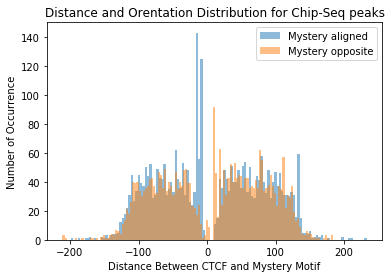

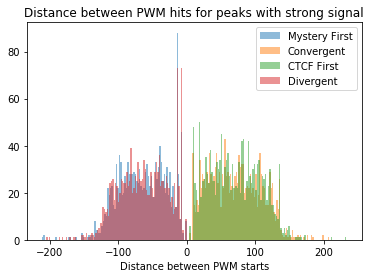

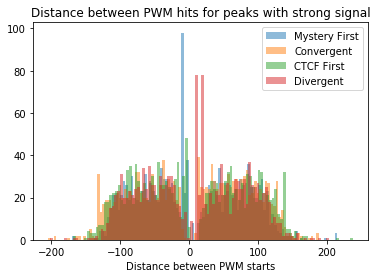

In [14]:
# is the motif stronger when in the correct orentation?
plt.hist(both[(both['omatch'] == 0)]['distance'], bins = 128, alpha = 0.5, label = 'Mystery aligned')
plt.hist(both[(both['omatch'] == 1)]['distance'], bins = 128, alpha = 0.5, label = 'Mystery opposite')
plt.legend()
plt.ylabel('Number of Occurrence')
plt.xlabel('Distance Between CTCF and Mystery Motif')
plt.title('Distance and Orentation Distribution for Chip-Seq peaks')
plt.show()

# how does distance vary with orentation?
plt.hist((both[(both['orentation'] == 1)]['distance']), bins = 100, alpha = 0.5, label = 'Mystery First')
plt.hist((both[(both['orentation'] == 2)]['distance']), bins = 100, alpha = 0.5, label = 'Convergent')
plt.hist((both[(both['orentation'] == 3)]['distance']), bins = 100, alpha = 0.5, label = 'CTCF First')
plt.hist((both[(both['orentation'] == 4)]['distance']), bins = 100, alpha = 0.5, label = 'Divergent')
plt.legend()
plt.title('Distance between PWM hits for peaks with strong signal')
plt.xlabel('Distance between PWM starts')
plt.show()

# how does distance vary with orentation?
plt.hist((both[(both['orentation'] == 1)]['old_distance']), bins = 100, alpha = 0.5, label = 'Mystery First')
plt.hist((both[(both['orentation'] == 2)]['old_distance']), bins = 100, alpha = 0.5, label = 'Convergent')
plt.hist((both[(both['orentation'] == 3)]['old_distance']), bins = 100, alpha = 0.5, label = 'CTCF First')
plt.hist((both[(both['orentation'] == 4)]['old_distance']), bins = 100, alpha = 0.5, label = 'Divergent')
plt.legend()
plt.title('Distance between PWM hits for peaks with strong signal')
plt.xlabel('Distance between PWM starts')
plt.show()

In [ ]:
# bin and plot the average score for each distance bracket with CTCF in the center sliding the mystery motif around 
bin_size=15
plt.title('Average Chip-Seq scores for Sequences from peaks')
plt.xlabel('Distance between PWM starts')
plt.ylabel('Average Chip-Seq Score ('+str(bin_size)+' wide bin)')


def bined_average_score(peaks, value, bin_size=10):
    avg_score = list()
    for i in range(-256, 256, bin_size):
        # do we have any sequence here?
        number_seqs = len(peaks[(peaks['distance'] < i+bin_size) & (peaks['distance'] > i)])
        summed_scores = sum(peaks[(peaks['distance'] < i+bin_size) & (peaks['distance'] > i)][value])
        if number_seqs != 0:
            avg_score.append(summed_scores/number_seqs)
        else:
            avg_score.append(0)
    return avg_score
        
        
plt.plot(bined_average_score(both[(both['orentation'] == 4)], 'signalValue', bin_size=bin_size), label = 'Divergent')
        
plt.axis([0,100,0,150])
plt.legend()
plt.show()

In [ ]:
# make a histogram of these datasets
plt.hist(peaks['score'], 100, alpha=.5, label='All Chip-seq Peaks')
plt.hist(both['score'], 100, alpha=.5, label='With Mystery Motif')
plt.hist(both[(abs(both['orentation']-2.5) < 1)]['score'], 100, alpha=.5, label='With Correct Orentation')
plt.hist(both[(abs(both['orentation']-2.5) > 1)]['score'], 100, alpha=.5, label='With Opposite Orentation')

plt.title('Chip-Seq binding strength with and without Mystery Motif')
plt.xlabel('Chip-Seq Signal Value')
plt.legend()
plt.show()

# plot average strength
objects = ('All Peaks', 'Mystery Motif', 'Correct', 'Opposite', 'CTCF First')
y_pos = np.arange(len(objects))
bar_width = 0.2
props = [sum(peaks['score'])/len(peaks), sum(both['score'])/len(both), sum(both[(abs(both['orentation']-2.5) < 1)]['score'])/len(both[(abs(both['orentation']-2.5) < 1)]), sum(both[(abs(both['orentation']-2.5) > 1)]['score'])/len(both[(abs(both['orentation']-2.5) > 1)])]
props.append(sum(both[both['orentation'] == 3]['score'])/len(both[both['orentation'] == 3]))
plt.bar(y_pos, props , bar_width, alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Average Chip-Seq Signal Value')
plt.title('Strength of CTCF binding for Chip-Seq peaks')
plt.show()

print('All Chip-seq Peaks ' + str(sum(peaks['score'])/len(peaks)))
print('With Mystery Motif ' + str(sum(both['score'])/len(both)))
print('With Correct Orientation ' + str(sum(both[(abs(both['orentation']-2.5) < 1)]['score'])/len(both[(abs(both['orentation']-2.5) < 1)])))
print('With Opposite Orientation ' + str(sum(both[(abs(both['orentation']-2.5) > 1)]['score'])/len(both[(abs(both['orentation']-2.5) > 1)])))
print('With Opposite Orientation ' + str(sum(both[both['orentation'] == 3]['score'])/len(both[both['orentation'] == 3])))

In [ ]:
# make a histogram of these datasets
plt.hist(peaks['signalValue'], 100, alpha=.5, label='All Chip-seq Peaks')
plt.hist(both['signalValue'], 100, alpha=.5, label='With Mystery Motif')
plt.hist(both[(abs(both['orentation']-2.5) < 1)]['signalValue'], 100, alpha=.5, label='With Correct Orentation')
plt.hist(both[(abs(both['orentation']-2.5) > 1)]['signalValue'], 100, alpha=.5, label='With Opposite Orentation')

plt.title('Chip-Seq binding strength with and without Mystery Motif')
plt.xlabel('Chip-Seq Signal Value')
plt.legend()
plt.show()


y_pos = np.arange(len(objects))
bar_width = 0.5
props = [sum(peaks['signalValue'])/len(peaks)]
props.append(sum(ctcf_only['signalValue'])/len(ctcf_only))
props.append(sum(mystery_only['signalValue'])/len(mystery_only))
props.append(sum(both['signalValue'])/len(both))
plt.bar(y_pos, props , bar_width, alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Average Chip-Seq Signal Value')
plt.title('Strength of CTCF binding for Chip-Seq peaks')
plt.show()

props.append(sum(both[(abs(both['orentation']-2.5) < 1)]['signalValue'])/len(both[(abs(both['orentation']-2.5) < 1)]))
props.append(sum(both[(abs(both['orentation']-2.5) > 1)]['signalValue'])/len(both[(abs(both['orentation']-2.5) > 1)]))
props.append(sum(both[both['orentation'] == 3]['signalValue'])/len(both[both['orentation'] == 3]))

print('All Chip-seq Peaks ' + str(sum(peaks['signalValue'])/len(peaks)))
print('With Mystery Motif ' + str(sum(both['signalValue'])/len(both)))
print('With Correct Orientation ' + str(sum(both[(abs(both['orentation']-2.5) < 1)]['signalValue'])/len(both[(abs(both['orentation']-2.5) < 1)])))
print('With Opposite Orientation ' + str(sum(both[(abs(both['orentation']-2.5) > 1)]['signalValue'])/len(both[(abs(both['orentation']-2.5) > 1)])))
print('With CTCF First ' + str(sum(both[both['orentation'] == 3]['signalValue'])/len(both[both['orentation'] == 3])))

In [ ]:
# correct orentation and close by??
distance_cutoff = 80

# make a histogram of these datasets
plt.hist(peaks['signalValue'], 100, alpha=.5, label='All Chip-seq Peaks')
plt.hist(both['signalValue'], 100, alpha=.5, label='With Mystery Motif')
plt.hist(both[(abs(both['orentation']-2.5) < 1)]['signalValue'], 100, alpha=.5, label='With Correct Orentation')
plt.hist(both[(abs(both['orentation']-2.5) > 1) & (abs(both['distance']) < distance_cutoff)]['signalValue'], 100, alpha=.5, label='With Orentation and Distance')

plt.title('Chip-Seq binding strength with and without Mystery Motif')
plt.xlabel('Chip-Seq Signal Value')
plt.legend()
plt.show()

# plot average strength
objects = ('All Peaks', 'CTCF', 'Both', 'Motif Towards', 'CTCF First', 'Other Orientation')
y_pos = np.arange(len(objects))
bar_width = 0.3
props = [sum(peaks['signalValue'])/len(peaks)]
props.append(sum(peaks[peaks['ctcf'] > ctcf_cutoff]['signalValue'])/len(peaks[peaks['ctcf'] > ctcf_cutoff]))
props.append(sum(both['signalValue'])/len(both))
props.append(sum(both[(abs(both['orentation']-2.5) < 1)]['signalValue'])/len(both[(abs(both['orentation']-2.5) < 1)]))
props.append(sum(both[(both['orentation'] == 3)]['signalValue'])/len(both[(both['orentation'] == 3)]))
props.append(sum(both[~(abs(both['orentation']-2.5) < 1)]['signalValue'])/len(both[~(abs(both['orentation']-2.5) < 1)]))
plt.bar(y_pos, props , bar_width, alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Average Chip-Seq Signal Value')
plt.title('Strength of CTCF binding for Chip-Seq peaks')
plt.show()

for name, value in zip(objects, props):
    print(name + ' ' + str(value))

In [ ]:
avg_score = list()
for i in range(5, 100):
    if len(both[(abs(both['distance']) < i) & (abs(both['distance']) > i -15)]) != 0:
        avg_score.append(sum(both[(abs(both['distance']) < i) & (abs(both['distance']) > i -15)]['signalValue'])/len(both[(abs(both['distance']) < i) & (abs(both['distance']) > i -15)]))
    else:
        avg_score.append(0)
    
plt.plot(avg_score, label = 'Both Motifs')

avg_score = list()
for i in range(5, 100):
    if len(both[~(abs(both['orentation']-2.5) < 1) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]) != 0:
        avg_score.append(sum(both[~(abs(both['orentation']-2.5) < 1) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]['signalValue'])/len(both[~(abs(both['orentation']-2.5) < 1) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]))
    else:
        avg_score.append(0)
    
plt.plot(avg_score, label = 'Wrong Orentation')

avg_score = list()
for i in range(5, 100):
    if len(both[(both['orentation'] == 3) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]) != 0:
        avg_score.append(sum(both[(both['orentation'] == 3) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]['signalValue'])/len(both[(both['orentation'] == 3) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]))
    else:
        avg_score.append(0)
    
plt.plot(avg_score, label = 'CTCF First')

avg_score = list()
not_mystery = peaks[peaks['mystery'] < mystery_cutoff]
for i in range(5, 100):
    if len(not_mystery[(not_mystery['orentation'] == 3) & (abs(not_mystery['distance']) < i) & (abs(not_mystery['distance']) > i -15)]) != 0:
        avg_score.append(sum(not_mystery[(not_mystery['orentation'] == 3) & (abs(not_mystery['distance']) < i) & (abs(not_mystery['distance']) > i -15)]['signalValue'])/len(not_mystery[(not_mystery['orentation'] == 3) & (abs(not_mystery['distance']) < i) & (abs(not_mystery['distance']) > i -15)]))
    else:
        avg_score.append(0)
        
plt.plot(avg_score, label = 'No Mystery Motif and CTCF "first"')
        
    
plt.axis([0,100,0,150])
plt.legend()
plt.title('Average Chip-Seq scores for Sequences from peaks')
plt.xlabel('Distance between PWM starts')
plt.ylabel('Average Chip-Seq Score (15 wide bin)')
plt.show()

In [ ]:
# for forward facing ctcf
forward_both = both['ctcf_orentation' == 0]
reverse_both = both['ctcf_orentation' == 1]

favg_score = list()
for i in range(5, 256//2):
    # do we have any sequence here?
    if len(forward_both[(abs(forward_both['distance']) < i) & (abs(forward_both['distance']) > i-10)]) != 0:
        favg_score.append(sum(forward_both[(abs(forward_both['distance']) < i) & (abs(forward_both['distance']) > i-10)]['signalValue'])/len(both[(abs(both['distance']) < i) & (abs(both['distance']) > i -15)]))
    else:
        avg_score.append(0)
        
ravg_score = list() 
for i in range(5, 256//2):
    # do we have any sequence here?
    if len(reverse_both[(abs(reverse_both['distance']) < i) & (abs(reverse_both['distance']) > i-10)]) != 0:
        favg_score.append(sum(reverse_both[(abs(forward_both['distance']) < i) & (abs(forward_both['distance']) > i-10)]['signalValue'])/len(both[(abs(both['distance']) < i) & (abs(both['distance']) > i -15)]))
    else:
        avg_score.append(0)
    
plt.plot(avg_score, label = 'Both Motifs')

avg_score = list()
for i in range(5, 100):
    if len(both[~(abs(both['orentation']-2.5) < 1) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]) != 0:
        avg_score.append(sum(both[~(abs(both['orentation']-2.5) < 1) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]['signalValue'])/len(both[~(abs(both['orentation']-2.5) < 1) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]))
    else:
        avg_score.append(0)
    
plt.plot(avg_score, label = 'Wrong Orentation')

avg_score = list()
for i in range(5, 100):
    if len(both[(both['orentation'] == 3) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]) != 0:
        avg_score.append(sum(both[(both['orentation'] == 3) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]['signalValue'])/len(both[(both['orentation'] == 3) & (abs(both['distance']) < i) & (abs(both['distance']) > i -15)]))
    else:
        avg_score.append(0)
    
plt.plot(avg_score, label = 'CTCF First')

avg_score = list()
not_mystery = peaks[peaks['mystery'] < mystery_cutoff]
for i in range(5, 100):
    if len(not_mystery[(not_mystery['orentation'] == 3) & (abs(not_mystery['distance']) < i) & (abs(not_mystery['distance']) > i -15)]) != 0:
        avg_score.append(sum(not_mystery[(not_mystery['orentation'] == 3) & (abs(not_mystery['distance']) < i) & (abs(not_mystery['distance']) > i -15)]['signalValue'])/len(not_mystery[(not_mystery['orentation'] == 3) & (abs(not_mystery['distance']) < i) & (abs(not_mystery['distance']) > i -15)]))
    else:
        avg_score.append(0)
        
plt.plot(avg_score, label = 'No Mystery Motif and CTCF "first"')
        
    
plt.axis([0,100,0,150])
plt.legend()
plt.title('Average Chip-Seq scores for Sequences from peaks')
plt.xlabel('Distance between PWM starts')
plt.ylabel('Average Chip-Seq Score (15 wide bin)')
plt.show()

In [ ]:
# ctcf scores as a function of distance from peak?
plt.hexbin(peaks['distance'], peaks['ctcf'], gridsize=50, bins='log', cmap='plasma')
plt.title('ctcf scores as a function of distance from peak')
plt.xlabel('Distance from PWM')
plt.ylabel('CTCF Score')
plt.show()